## Data Understanding

In [55]:
#importing libraries
import os 
import cv2
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.utils import image_dataset_from_directory
%matplotlib inline  

In [56]:
# Load the dataset
dataset_folder = r"data/UTKFace/"

In [57]:
image_paths = []
age_labels = []
gender_labels = []
race_labels= []

for filename in tqdm(os.listdir(dataset_folder)):
    image_path = os.path.join(dataset_folder, filename)
    file_name = os.path.split(image_path)[1]
    temp = filename.split('_')
    age = temp[0]
    gender = temp[1]
    race = temp[2]
    image_paths.append(file_name)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)

100%|██████████| 9780/9780 [00:00<00:00, 47886.00it/s]


In [58]:
# Creating a dataframe for the images,ages,genders and races
df = pd.DataFrame()
df['image'], df['age'], df['gender'],df["race"] = image_paths, age_labels, gender_labels, race_labels
df.head()

,image,age,gender,race
0,100_1_0_20170110183726390.jpg.chip.jpg,100,1,0
1,100_1_2_20170105174847679.jpg.chip.jpg,100,1,2
2,101_1_2_20170105174739309.jpg.chip.jpg,101,1,2
3,10_0_0_20161220222308131.jpg.chip.jpg,10,0,0
4,10_0_0_20170103200329407.jpg.chip.jpg,10,0,0


In [59]:
class DataUnderstanding:
    """This is a class that does basic data understanding"""
    def __init__(self, df):
        self.df = df
        self.shape = "The shape is: {} with {} records and {} columns".format(df.shape,df.shape[0],df.shape[1])
        self.info = df.info
        self.duplicates = "There are {} duplicates in the dataframe".format(df.duplicated().sum())
        self.missing = df.isna().sum()
        self.types = df.dtypes
    def counts(self, col, df=df):
        self.value_counts = df[col].value_counts()
        return self.value_counts
        


In [60]:
# Initialize the class
data_und = DataUnderstanding(df)

### General info about the dataframe

In [61]:
data_und.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9780 entries, 0 to 9779
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   9780 non-null   object
 1   age     9780 non-null   object
 2   gender  9780 non-null   object
 3   race    9780 non-null   object
dtypes: object(4)
memory usage: 305.8+ KB


In [62]:
data_und.duplicates

'There are 0 duplicates in the dataframe'

In [63]:
data_und.missing

image     0
age       0
gender    0
race      0
dtype: int64

In [64]:
data_und.types

image     object
age       object
gender    object
race      object
dtype: object

### The value counts for the columns

In [65]:
data_und.counts("age")

1      1112
2       475
3       284
26      279
4       260
       ... 
110       2
99        2
100       2
91        1
101       1
Name: age, Length: 99, dtype: int64

In [66]:
data_und.counts("gender")

1    5407
0    4372
3       1
Name: gender, dtype: int64

In [67]:
data_und.counts("race")

0                                 5265
2                                 1553
3                                 1452
4                                 1103
1                                  405
20170109142408075.jpg.chip.jpg       1
20170109150557335.jpg.chip.jpg       1
Name: race, dtype: int64

## Data Preparation

In [68]:
# Dropping row where the gender==3 and races are not integers between 0 and 4 inclusive
# df = df[df["gender"]!=3]
df = df.loc[df["race"].isin(["0","1","2","3","4"]) & (df["gender"] != "3")]

data_und= DataUnderstanding(df)
data_und.shape

'The shape is: (9778, 4) with 9778 records and 4 columns'

In [69]:
data_und.counts("gender",df=df)

1    5406
0    4372
Name: gender, dtype: int64

In [70]:
data_und.counts("race",df=df)

0    5265
2    1553
3    1452
4    1103
1     405
Name: race, dtype: int64

In [71]:
data_und.duplicates

'There are 0 duplicates in the dataframe'

In [72]:
# Proper object types
convert_dict = {'age': int,
                'gender': int,
                "race": int
                }
 
df = df.astype(convert_dict)
df.head(10)

,image,age,gender,race
0,100_1_0_20170110183726390.jpg.chip.jpg,100,1,0
1,100_1_2_20170105174847679.jpg.chip.jpg,100,1,2
2,101_1_2_20170105174739309.jpg.chip.jpg,101,1,2
3,10_0_0_20161220222308131.jpg.chip.jpg,10,0,0
4,10_0_0_20170103200329407.jpg.chip.jpg,10,0,0
5,10_0_0_20170103200522151.jpg.chip.jpg,10,0,0
6,10_0_0_20170103233459275.jpg.chip.jpg,10,0,0
7,10_0_0_20170104013211746.jpg.chip.jpg,10,0,0
8,10_0_0_20170110215927291.jpg.chip.jpg,10,0,0
9,10_0_0_20170110220033115.jpg.chip.jpg,10,0,0


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9778 entries, 0 to 9779
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   9778 non-null   object
 1   age     9778 non-null   int32 
 2   gender  9778 non-null   int32 
 3   race    9778 non-null   int32 
dtypes: int32(3), object(1)
memory usage: 267.4+ KB


## Exploratory Data Analysis

In [74]:
# EDA class
class EdaAnalysis:    
    def univariate(self,df,col1,labels_dict=None):
        """ A function that does univariate analysis"""
        plt.figure(figsize=(16,8))
        sns.countplot(x=col1,data=df, palette='colorblind')
        plt.title(f'No of images per {col1}')
        plt.xlabel(col1)
        plt.xticks(rotation=45)
        handles = [Patch(color=color, label=labels_dict[key]) for key, color in zip(labels_dict.keys(), sns.color_palette("colorblind", len(labels_dict))) ]
        plt.legend(handles=handles)
        
        
    def bivariate(self,df,col1, col2):
        """ A function that does bivariate analysis"""
        plt.figure(figsize=(16,8))
        sns.countplot(x=col1, data= df,hue=col2)
        plt.title(f'{col1} on {col2}')
        plt.ylabel(f'count of {col1}')
        plt.legend(title=col2)
        
        
    def multivariate_analysis(self, df):
      
        """Perform multivariate analysis on the data"""
        # Calculate the pairwise Pearson correlation coefficients for all columns
        corr_matrix = df.corr()
        # Plot a heatmap to visualize the correlations
        sns.heatmap(corr_matrix)

In [75]:
# Initialize the EDA class
plot = EdaAnalysis()

### Univariate Analysis

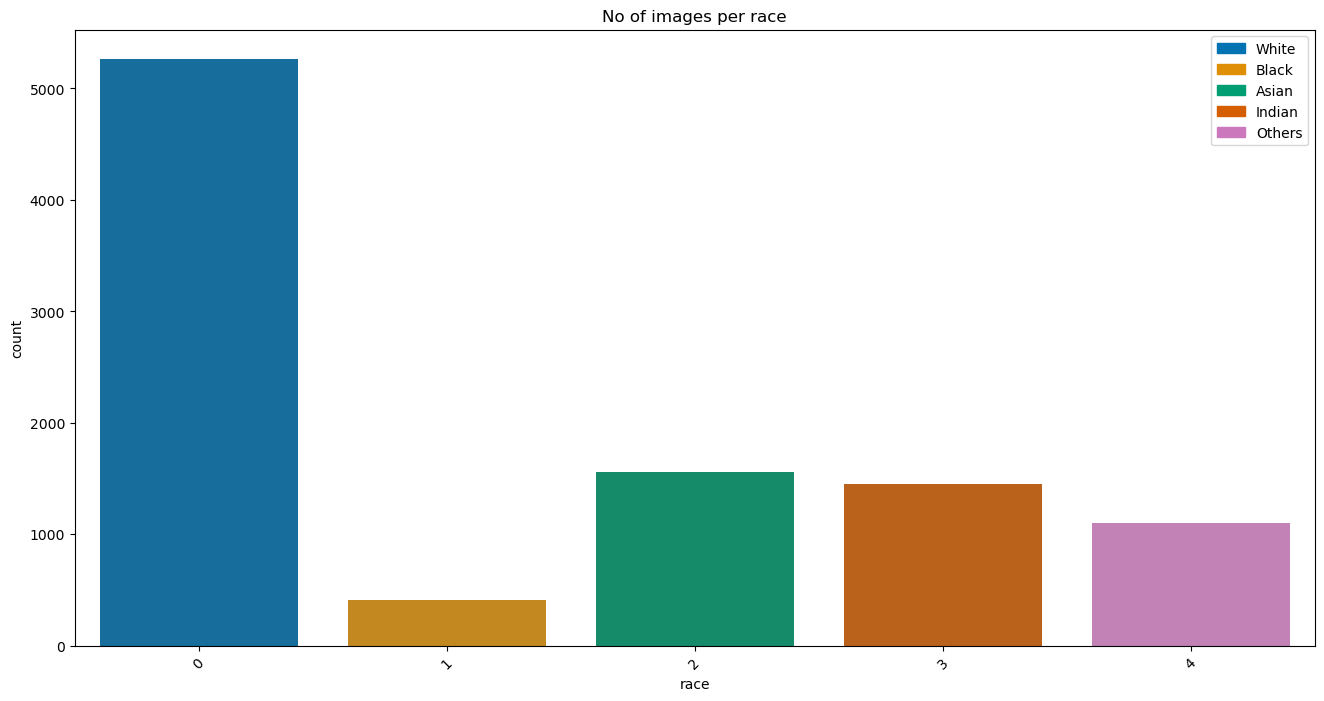

In [76]:
plot.univariate(df,"race",{0:"White",
                        1:"Black",
                        2:"Asian",
                        3:"Indian",
                        4:"Others"})

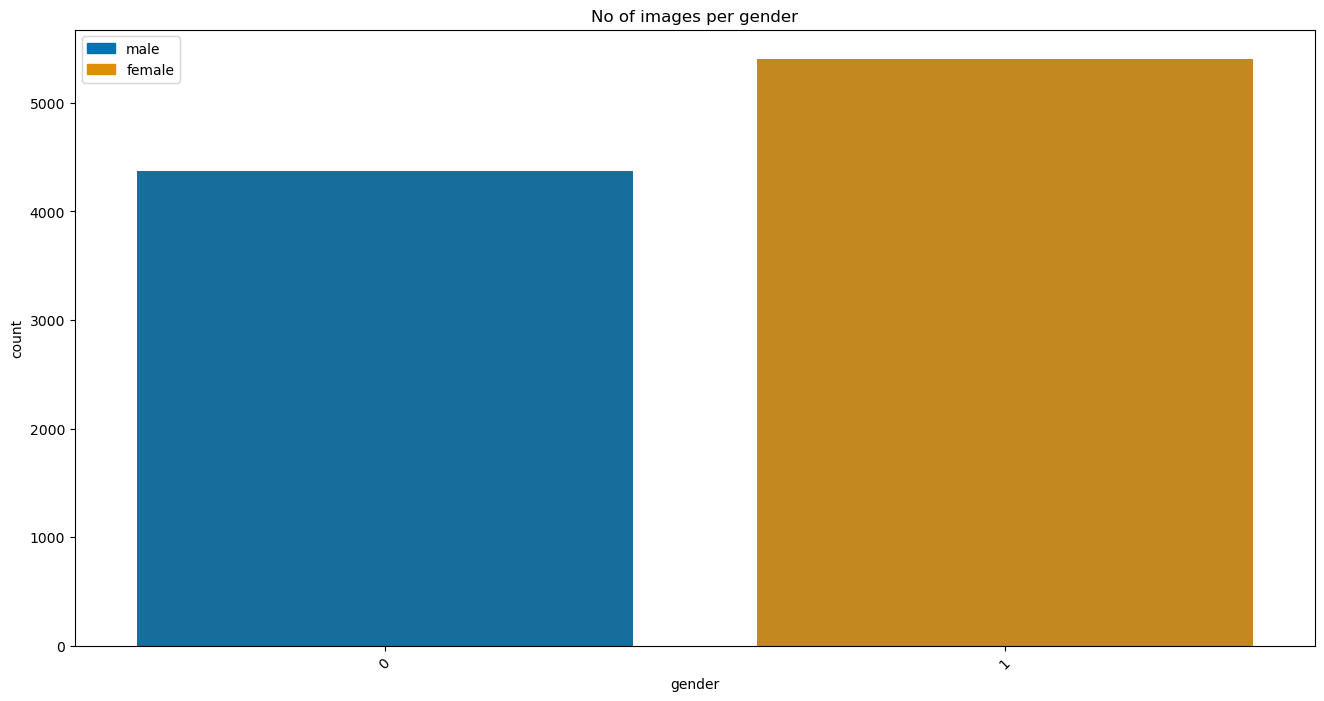

In [77]:
plot.univariate(df,"gender",{0:"male",1:"female"})

In [78]:
# Create the bins
bins = range(0, 111, 10)

# Create the names for the bins
names = {group: f'{group * 10}-{(group + 1) * 10}' for group in range(0, 11)}.values()

# Bin the data
df['age_binned'] = pd.cut(df["age"], bins, labels=names)
df.head()

,image,age,gender,race,age_binned
0,100_1_0_20170110183726390.jpg.chip.jpg,100,1,0,90-100
1,100_1_2_20170105174847679.jpg.chip.jpg,100,1,2,90-100
2,101_1_2_20170105174739309.jpg.chip.jpg,101,1,2,100-110
3,10_0_0_20161220222308131.jpg.chip.jpg,10,0,0,0-10
4,10_0_0_20170103200329407.jpg.chip.jpg,10,0,0,0-10


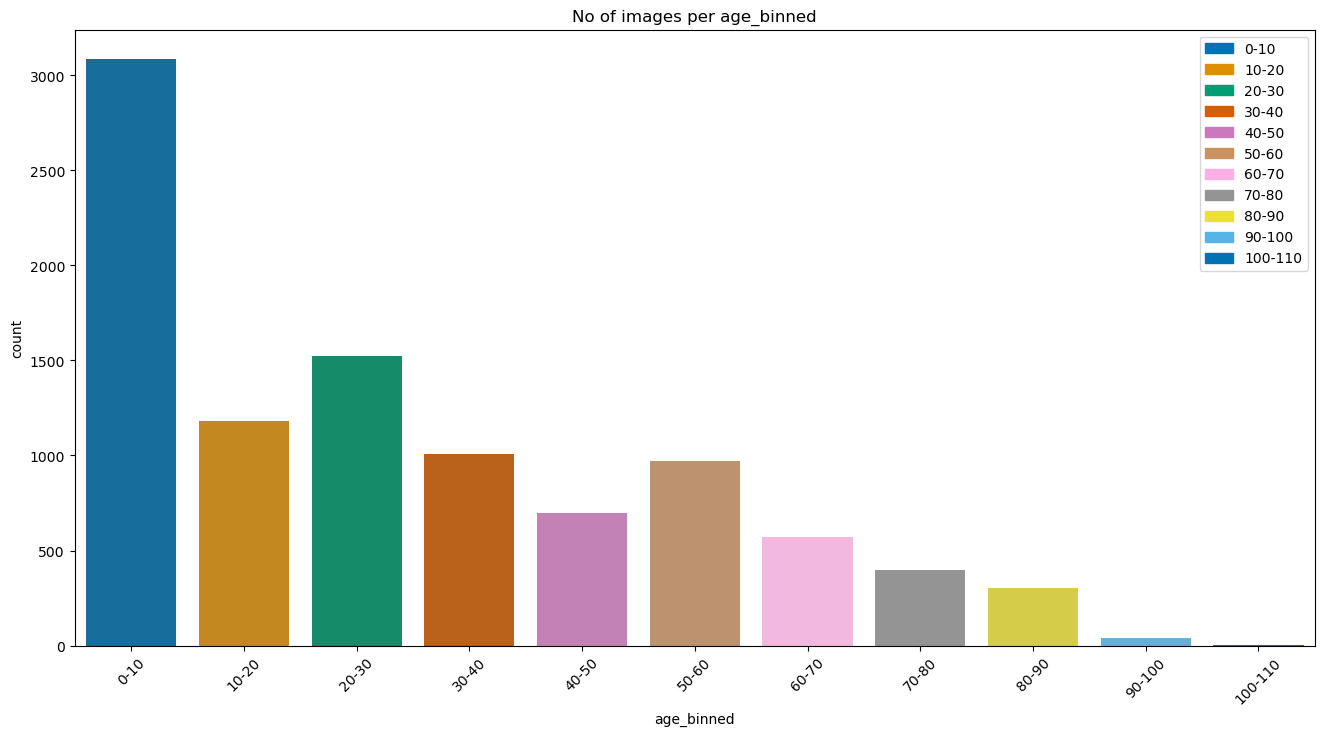

In [79]:
plot.univariate(df, 'age_binned',{group: f'{group * 10}-{(group + 1) * 10}' for group in range(0, 11)})

### Bivariate Analysis

## Data Preprocessing

In [80]:
import glob
from sklearn.model_selection import train_test_split
from keras.utils import load_img, to_categorical


In [81]:
data_dir = os.getcwd()
file_pattern = os.path.join(data_dir, "data", "UTKFace","*.jpg")
file_names = glob.glob(file_pattern)

In [82]:
# Split the filenames into training and test sets
train_set, val_set = train_test_split(file_names, test_size=0.2, random_state=230)
print("""
    Number of training images: {}
    Number of validation images: {}
""".format(len(train_set),len(val_set)))


    Number of training images: 7824
    Number of validation images: 1956



In [83]:
df.columns

Index(['image', 'age', 'gender', 'race', 'age_binned'], dtype='object')

In [84]:
len(df.gender.value_counts())

2

In [85]:
IM_WIDTH = IM_HEIGHT = 198

In [86]:
def generate_images(image_idx, is_training, batch_size=16):     
    images, ages, races, genders = [], [], [], []
    while True:
        for idx in image_idx:
            person = df.iloc[idx]

            age = person['age']
            race = person['race']
            gender = person['gender']
            file = person['image']
            
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            
            ages.append(age / df.age.max())
            races.append(to_categorical(race, len(df.race.value_counts())))
            genders.append(to_categorical(gender, len(df.gender.value_counts())))
            images.append(im)
            
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
                
        if not is_training:
            break

### CNN Model built in a MultiTasking Manner

In [94]:
import tensorflow as tf
from keras.models import Model
from keras import Sequential
from keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Dropout,Lambda,Dense,Flatten,Input
from keras.losses import SparseCategoricalCrossentropy
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKerasTF


In [88]:
input_shape = (128, 128, 3)

In [89]:
class UtkMultiOutputModel():
    def make_default_hidden_layers(self, inputs):
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)        
        return x  
       
    def build_race_branch(self, inputs, num_races):
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_races)(x)
        x = Activation("softmax", name="race_output")(x)        
        return x  
    
    def build_gender_branch(self, inputs, num_genders=2): 
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)        
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)        
        return x  

    def build_age_branch(self, inputs):            
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)        
        return x 
    
    def assemble_full_model(self, width, height, num_races):       
        input_shape = (height, width, 3)        
        inputs = Input(shape=input_shape)        
        age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs, num_races)
        gender_branch = self.build_gender_branch(inputs)        
        model = Model(inputs=inputs,
                     outputs = [age_branch, race_branch, gender_branch],
                     name="face_net")        
        return model

In [90]:
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=len(df.race.value_counts()))

In [91]:
model.summary()

Model: "face_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 198, 198, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 198, 198, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 198, 198, 16  448         ['input_2[0][0]']                
                                )                                                          

In [92]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [96]:
init_lr = 1e-4
epochs = 50

In [97]:
opt = Adam(learning_rate=init_lr, decay=init_lr / epochs)
model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse',
                  'gender_output': 'binary_crossentropy',
                  'ethnicity_output': 'sparse_categorical_crossentropy'},
              
              loss_weights={
                  'age_output': 4., 
                  'gender_output': 0.1,
                  'ethnicity_output': 1.5},
              
              metrics={
                  'age_output': 'mae', 
                  'gender_output': 'accuracy',
                  'ethnicity_output': 'accuracy'})

### Training the model

In [ ]:
batch_size = 32
valid_batch_size = 32

In [ ]:
data_generator = UtkMultiOutputModel(df)
train_gen = data_generator.generate_images(train_set, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(val_set, is_training=True, batch_size=valid_batch_size)
checkpoint = ModelCheckpoint("Best_model_params.h5", monitor='val_loss')
callbacks = [PlotLossesKerasTF(), checkpoint]


In [ ]:
history = model.fit(train_gen,
                    steps_per_epoch=len(train_set)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(val_set)//valid_batch_size)